# Analyze the time delay (the delay in each time interval).

The data from the change task is incorrect, as it calculates negative latency values. However, the data from the add task accurately represents the state of latency with raw image transfer.

In [3]:
import matplotlib.pyplot as plt
import os
import re
import chardet

In [4]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read(10000)  # 读取部分数据用于编码检测
        result = chardet.detect(raw_data)
        encoding = result['encoding']
        return encoding if encoding else 'utf-8'  # 如果检测结果为空，则默认使用 utf-8

In [6]:
def extract_data(filepath):
    encoding = detect_encoding(filepath)  # 检测文件编码
    data = {'Time_recv2play': [], 'Total_time': [], 'Time_cap2send': []}
    try:
        with open(filepath, 'r', encoding=encoding) as file:
            for line in file:
                line = line.strip()
                if 'Time_recv2play' in line:
                    value = int(line.split(':')[1])
                    data['Time_recv2play'].append(value)
                elif 'Total_time' in line:
                    value = int(line.split(':')[1])
                    data['Total_time'].append(value)
                elif 'Time_cap2send' in line:
                    value = int(line.split(':')[1])
                    data['Time_cap2send'].append(value)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")  # 打印错误信息
        return data  # 即使发生错误也返回当前收集的部分数据
    return data

In [7]:
def plot_data(data, title):
    """Plots boxplots for given data."""
    plt.figure(figsize=(8, 5))
    keys = list(data.keys())
    values = [data[key] for key in keys]
    plt.boxplot(values, labels=keys, notch=True, patch_artist=True, showfliers=False)
    plt.title(title)
    plt.ylabel('Time (ms)')
    plt.show()

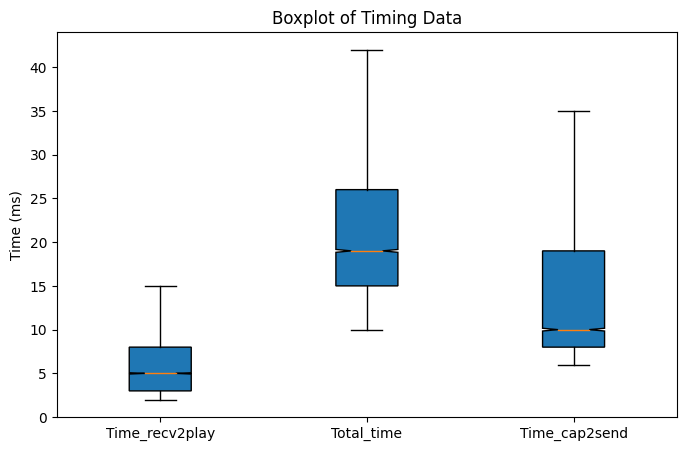

In [8]:
def process_files(directory):
    all_data = {'Time_recv2play': [], 'Total_time': [], 'Time_cap2send': []}
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            data = extract_data(filepath)
            for key in all_data:
                if data and key in data:  # 确保 data 是有效的且包含所需的键
                    all_data[key].extend(data[key])

    # 绘制所有聚合数据的箱形图
    plot_data(all_data, 'Boxplot of Timing Data')

# Provide the path to the directory containing your text files
process_files(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0701\10times_add_0701\camera_latency')


In [10]:
from scapy.all import rdpcap, UDP,  defragment, IP
import pandas as pd
from decimal import Decimal
import time

In [2]:
def read_timestamps(txt_path):
    with open(txt_path, 'r') as file:
        lines = file.readlines()
    timestamps = [tuple(map(int, line.strip().split(','))) for line in lines]
    return timestamps

In [24]:
def analyze_pcap(pcap_path, udp_port=8888):
    packets = rdpcap(pcap_path)
    # 使用Scapy的defragment函数来重新组装分片
    packets = defragment(packets)
    packet_times = {}
    for packet in packets:
        if IP in packet and UDP in packet and packet[UDP].dport == udp_port:
            try:
                payload = bytes(packet[UDP].payload)
                # 假设时间戳在数据的末尾，确保使用正确的byteorder
                low_bits = int.from_bytes(payload[-8:], byteorder='little')
                low_32 = low_bits & 0xFFFFFFFF
                high_32 = (low_bits >> 32) & 0xFFFFFFFF
                current_time_high_32 = (int(time.time() * 1e6) >> 32) & 0xFFFFFFFF
                restored_timestamp = (current_time_high_32 << 32) | low_32
                packet_times[restored_timestamp] = packet.time
            except:
                continue
    return packet_times

In [4]:
def calculate_delays(capture_send, send_receive_play, client_packets, server_packets):
    # Create an empty DataFrame
    df = pd.DataFrame(columns=['capture', 'send', 'receive', 'play', 'cap_to_send', 'app_to_nic', 'nic_to_nic', 'nic_to_app', 'receive_to_play', 'total_delay'])
    
    # Iterate through the timing data
    #for capture, send in capture_send:
    for cap, send, receive, play in send_receive_play:
        if  cap in client_packets and cap in server_packets:
            # Convert Decimal to float
            client_time = float(client_packets[cap])*1000000
            server_time = float(server_packets[cap])*1000000

            # Build a new row for DataFrame
            new_row = {
                'capture': cap,
                'send': send,
                'receive': receive,
                'play': play,
                'cap_to_send' : send - cap,
                'app_to_nic': client_time - float(send),
                'nic_to_nic': server_time - client_time,
                'nic_to_app': float(receive) - server_time,
                'receive_to_play': float(play) - float(receive),
                'total_delay': float(play) - cap
            }
            new_row_df = pd.DataFrame([new_row])  # Convert dictionary to a DataFrame
            df = pd.concat([df, new_row_df], ignore_index=True)
    
    return df

In [5]:
#capture_send_times = read_timestamps(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0709\camera_client_raw.txt')
#send_receive_play_times = read_timestamps(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0709\camera_server_raw.txt')
capture_send_times = read_timestamps(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\10times_add_071903\camera_client_raw.txt')
send_receive_play_times = read_timestamps(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\10times_add_071903\camera_server_raw.txt')

In [ ]:
#client_packets_times = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0709\10times_add_client_camera_0709.pcapng')
#server_packets_times = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0709\10times_add_server_0709.pcapng')
client_packets_times = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\10times_add_071903\10times_add_client_camera_071903.pcapng')
server_packets_times = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\10times_add_071903\10times_add_server_071903.pcapng')

In [23]:
delays = calculate_delays(capture_send_times, send_receive_play_times, client_packets_times, server_packets_times)
delays.to_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\10times_add_071903\latency_camera.csv', sep=',', index=False)

around 1720447345179 the latency increase to 300ms

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载CSV文件
df = pd.read_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\10times_add_071903\latency_camera.csv')

# 选择要绘制的列
columns_to_plot = ['cap_to_send', 'app_to_nic', 'nic_to_nic', 'nic_to_app', 'receive_to_play', 'total_delay']

medians = df[columns_to_plot].median()
print("Medians of the selected columns:")
print(medians)

# 绘制箱体图
plt.figure(figsize=(12, 8))  # 设置图形大小
df[columns_to_plot].boxplot(showfliers=False)  # 使用DataFrame的boxplot方法绘制
plt.title('Boxplot of Time Delays')  # 添加标题
plt.ylabel('Microseconds')  # 设置y轴标签
plt.xticks(rotation=45)  # 旋转x轴标签，使其更易读
plt.grid(True)  # 添加网格线
plt.show()  # 显示图形

Medians of the selected columns:
cap_to_send        21.000000
app_to_nic         -0.385010
nic_to_nic          5.892822
nic_to_app         -0.415039
receive_to_play     6.000000
total_delay        34.000000
dtype: float64


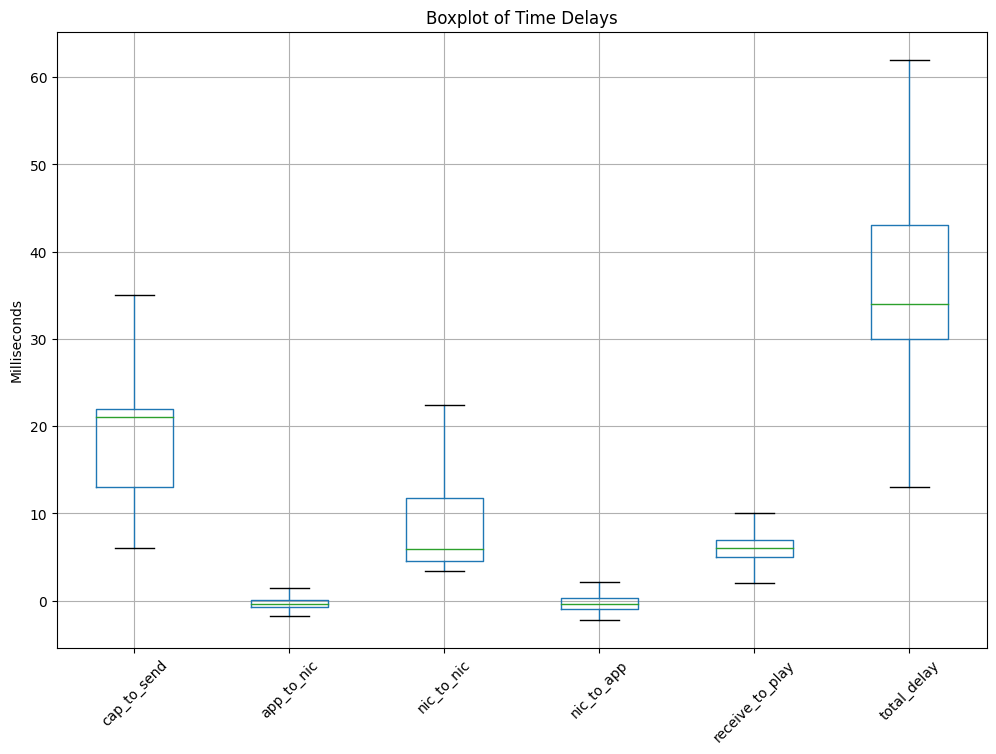

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载CSV文件
df = pd.read_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0708\10times_add_0708\latency_camera.csv')

# 选择要绘制的列
columns_to_plot = ['cap_to_send', 'app_to_nic', 'nic_to_nic', 'nic_to_app', 'receive_to_play', 'total_delay']


medians = df[columns_to_plot].median()
print("Medians of the selected columns:")
print(medians)

# 绘制箱体图
plt.figure(figsize=(12, 8))  # 设置图形大小
df[columns_to_plot].boxplot(showfliers=False)  # 使用DataFrame的boxplot方法绘制
plt.title('Boxplot of Time Delays')  # 添加标题
plt.ylabel('Milliseconds')  # 设置y轴标签
plt.xticks(rotation=45)  # 旋转x轴标签，使其更易读
plt.grid(True)  # 添加网格线
plt.show()  # 显示图形

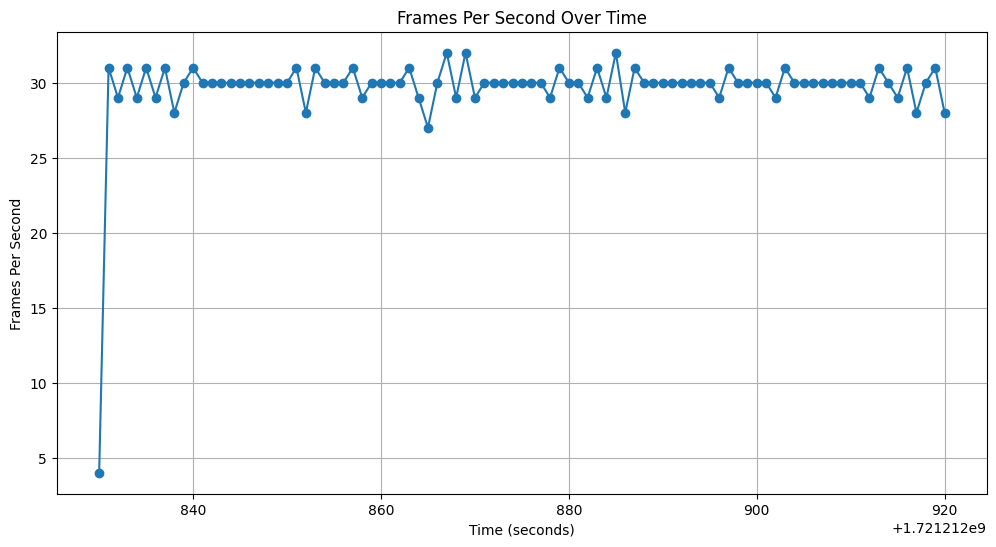

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载CSV文件
df = pd.read_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\10times_add_071702\latency_camera.csv')

# 将播放时间从毫秒转换为秒，用于分组
df['second'] = df['play'] // 1000000

# 计算每秒内的帧数
fps_per_second = df.groupby('second').size()

# 可视化每秒的帧数
plt.figure(figsize=(12, 6))
fps_per_second.plot(marker='o', linestyle='-')
plt.title('Frames Per Second Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Frames Per Second')
plt.grid(True)
plt.show()

## process the json of webrtc internal dumps

176 86
10.138965909090908 41.792116279069774


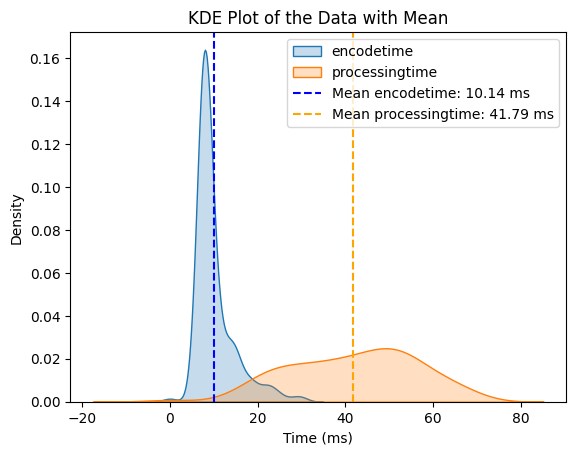

In [5]:
import json
import matplotlib.pyplot as plt
import ast
import numpy as np
import seaborn as sns

# 读取 JSON 文件

#Client data
####################
client_file_path = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\webrtc_internals_dump_client.txt'

with open(client_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

total_encodetime = data['PeerConnections']['19-1']['stats']['OT01V1107352475-[totalEncodeTime/framesEncoded_in_ms]']['values']

total_encodetime = ast.literal_eval(total_encodetime)

total_encodetime = [round(float(x), 3) for x in total_encodetime]


######################
#Server data
client_file_path = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\webrtc_internals_dump_server.txt'

with open(client_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

total_processing_time = data['PeerConnections']['31-1']['stats']['IT01V1107352475-[totalProcessingDelay/framesDecoded_in_ms]']['values']

total_processing_time = ast.literal_eval(total_processing_time)

total_processing_time = [round(float(x), 3) for x in total_processing_time]



####################

data = [total_encodetime, total_processing_time]

# print(len(data[0]),len(data[1]))
# print(np.mean(data[0]),np.mean(data[1]))

# plt.boxplot(data)
# #sns.kdeplot(data)
# plt.xticks([1, 2], ['encodetime', 'processingtime'])

# plt.title('Boxplot of the Data')
# plt.ylabel('ms')

# # 显示图表
# plt.show()

mean_encodetime = np.mean(data[0])
mean_processingtime = np.mean(data[1])

# 打印数据长度和均值
print(len(data[0]), len(data[1]))
print(mean_encodetime, mean_processingtime)

# 绘制 KDE 图
sns.kdeplot(data[0], label='encodetime', fill=True)  # 绘制 total_encodetime 的 KDE 曲线
sns.kdeplot(data[1], label='processingtime', fill=True)  # 绘制 total_processing_time 的 KDE 曲线

# 标注均值位置
plt.axvline(mean_encodetime, color='blue', linestyle='--', label=f'Mean encodetime: {mean_encodetime:.2f} ms')
plt.axvline(mean_processingtime, color='orange', linestyle='--', label=f'Mean processingtime: {mean_processingtime:.2f} ms')

# 设置图例、标题和标签
plt.legend()
plt.xticks()  # 可以保留默认的 x 轴刻度
plt.title('KDE Plot of the Data with Mean')
plt.xlabel('Time (ms)')
plt.ylabel('Density')

# 显示图表
plt.show()



# NIC to NIC

In [1]:
import pandas as pd
from scapy.all import rdpcap, PacketList

def load_packets(filename):
    # 读取pcapng文件并返回PacketList
    return rdpcap(filename)

def extract_time_id(packets):
    # 提取时间和ID code
    data = []
    for packet in packets:
        if 'IP' in packet:
            id_code = str(packet['IP'].id)  # 假设ID code存储在IP包的ID字段
            time = packet.time
            data.append((time, id_code))
    return pd.DataFrame(data, columns=['time', 'id_code'])

def find_earliest_common_time(df1, df2):
    # 找到两个数据框中的最早共有时间
    earliest_time1 = df1['time'].min()
    earliest_time2 = df2['time'].min()
    return max(earliest_time1, earliest_time2)

def analyze_latency_and_losses(df1, df2, threshold=0.050):
    # 分析延迟和丢包
    min_common_time = find_earliest_common_time(df1, df2)
    df1 = df1[df1['time'] >= min_common_time]
    df2 = df2[df2['time'] >= min_common_time]

    results = {
        'client_time': [],
        'id_code': [],
        'latency': [],
        'status': []
    }
    
    for index, row in df1.iterrows():
        id_code = row['id_code']
        client_time = row['time']
        matching_times = df2[(df2['id_code'] == id_code) & 
                             (df2['time'] >= client_time) & 
                             (df2['time'] <= client_time + threshold)]
        
        if not matching_times.empty:
            latency = matching_times['time'].min() - client_time
            results['client_time'].append(client_time)
            results['id_code'].append(id_code)
            results['latency'].append(latency)
            results['status'].append('Received')
        else:
            results['client_time'].append(client_time)
            results['id_code'].append(id_code)
            results['latency'].append(None)
            results['status'].append('Lost')

    return pd.DataFrame(results)

def analyze_per_second(df):
    # 确保时间戳以秒为单位
    df['second'] = df['client_time'].apply(lambda x: int(x))
    
    # 分组计算每秒的平均延迟和丢包率
    grouped = df.groupby('second')
    stats_per_second = grouped.agg(
        average_latency=('latency', 'mean'),
        total_packets=('id_code', 'count'),
        received_packets=('status', lambda x: (x == 'Received').sum()),
        lost_packets=('status', lambda x: (x == 'Lost').sum())
    )
    
    # 计算丢包率
    stats_per_second['loss_rate'] = stats_per_second['lost_packets'] / stats_per_second['total_packets']
    
    # 返回处理后的数据框
    return stats_per_second

import matplotlib.pyplot as plt

def plot_latency_and_loss_separately(df_stats, latency_path, ploss_path):
    # 检查是否有足够的数据进行绘图
    if df_stats.empty:
        print("No data available to plot.")
        return

    # 绘制延迟图
    plt.figure(figsize=(10, 5))
    plt.scatter(df_stats.index, df_stats['average_latency'], color='tab:red')
    plt.title('Average Latency Per Second')
    plt.xlabel('Second')
    plt.ylabel('Average Latency (s)')
    plt.grid(True)
    plt.savefig(latency_path)
    plt.show()

    # 绘制丢包率图
    plt.figure(figsize=(10, 5))
    plt.scatter(df_stats.index, df_stats['loss_rate'], color='tab:blue')
    plt.title('Loss Rate Per Second')
    plt.xlabel('Second')
    plt.ylabel('Loss Rate')
    plt.grid(True)
    plt.savefig(ploss_path)
    plt.show()


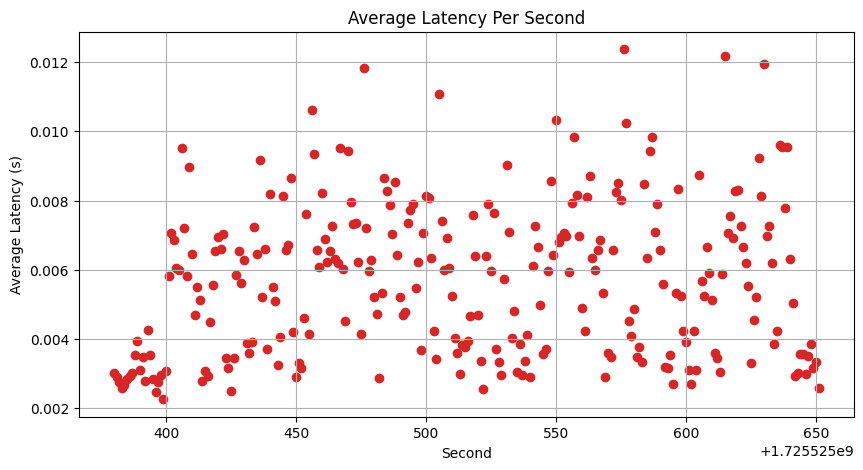

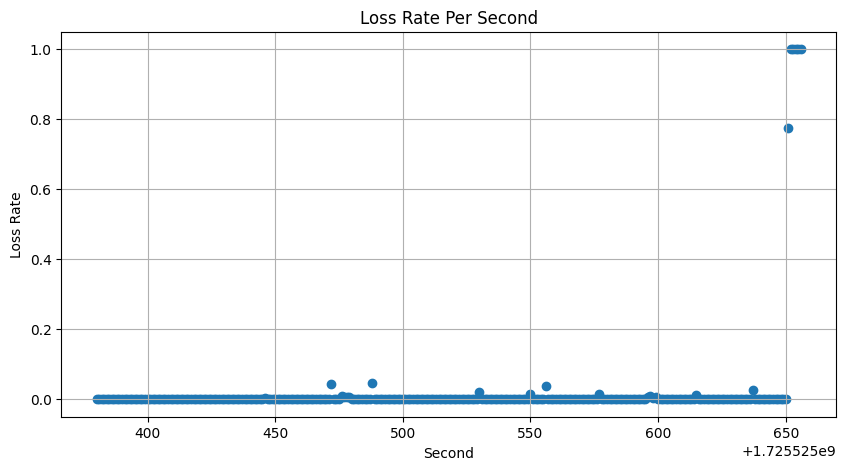

In [2]:

# ###############

packets1 = load_packets(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\camera_client_filter.pcapng")
packets2 = load_packets(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\camera_server_filter.pcapng")

df1 = extract_time_id(packets1)
df2 = extract_time_id(packets2)
path1 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\result\latency.png'
path2 = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\result\ploss.png'
result_df = analyze_latency_and_losses(df1, df2)
df_stats = analyze_per_second(result_df)
plot_latency_and_loss_separately(df_stats,latency_path=path1,ploss_path=path2)


NameError: name 'data' is not defined

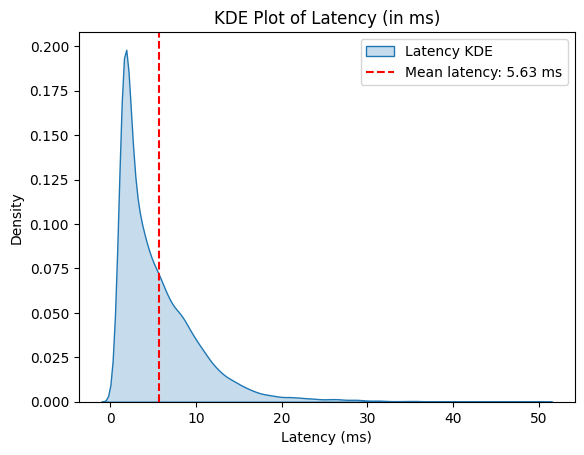

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 假设 result_df 是之前从 analyze_latency_and_losses() 函数得到的数据
latency_data = result_df['latency']

# 将时延数据从秒转换为毫秒
latency_data_ms = latency_data * 1000

# 计算均值（以毫秒为单位）
mean_latency_ms = np.mean(latency_data_ms)

# 绘制KDE图
sns.kdeplot(latency_data_ms, fill=True, label='Latency KDE')

# 标注均值
plt.axvline(mean_latency_ms, color='red', linestyle='--', label=f'Mean latency: {mean_latency_ms:.2f} ms')

# 设置图例、标题和标签
plt.legend()
plt.title('KDE Plot of Latency (in ms)')
plt.xlabel('Latency (ms)')
plt.ylabel('Density')

sns.kdeplot(data[0], label='encodetime', fill=True)  # 绘制 total_encodetime 的 KDE 曲线
sns.kdeplot(data[1], label='processingtime', fill=True)  # 绘制 total_processing_time 的 KDE 曲线

# 标注均值位置
plt.axvline(mean_encodetime, color='blue', linestyle='--', label=f'Mean encodetime: {mean_encodetime:.2f} ms')
plt.axvline(mean_processingtime, color='orange', linestyle='--', label=f'Mean processingtime: {mean_processingtime:.2f} ms')

# 设置图例、标题和标签
plt.legend()
plt.xticks()  # 可以保留默认的 x 轴刻度
plt.xlim(0, 100)
plt.title('KDE Plot of the Data with Mean')
plt.xlabel('Time (ms)')
plt.ylabel('Density')

# 显示图表
plt.show()
# 显示图表


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


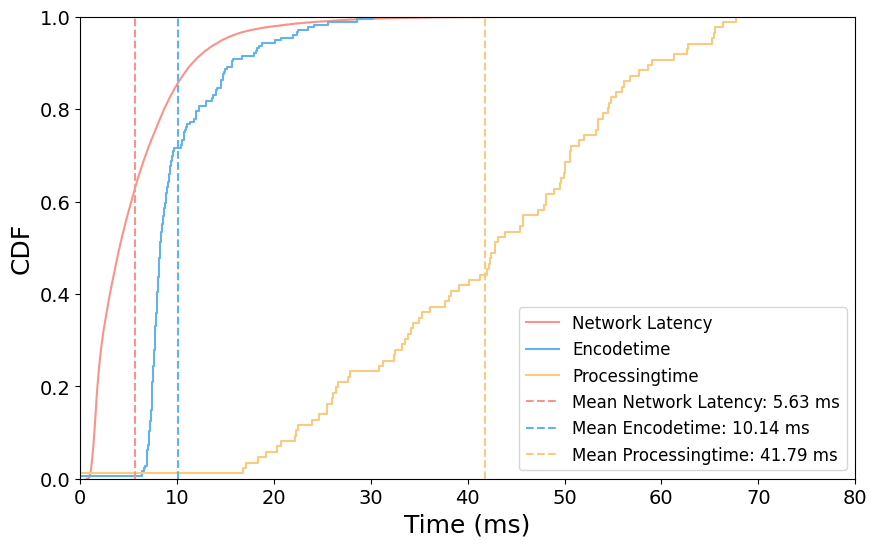

In [46]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 假设 result_df 是之前从 analyze_latency_and_losses() 函数得到的数据
latency_data = result_df['latency']

# 将时延数据从秒转换为毫秒
latency_data_ms = latency_data * 1000

latency_data_ms = latency_data_ms[latency_data_ms >= 0]
encodetime_ms = np.array(data[0])
encodetime_ms = encodetime_ms[encodetime_ms >= 0]

processingtime_ms = np.array(data[1])
processingtime_ms = processingtime_ms[processingtime_ms >= 0]

# 计算均值（以毫秒为单位）
mean_latency_ms = np.mean(latency_data_ms)
mean_encodetime = np.mean(data[0] * 1000)  # 确保 encodetime 数据也转换为毫秒
mean_processingtime = np.mean(data[1] * 1000)  # 确保 processingtime 数据也转换为毫秒

# 设置图形大小
plt.figure(figsize=(10, 6))

# 绘制 CDF 图
sns.ecdfplot(latency_data_ms, label='Network Latency', color='#f89588')
sns.ecdfplot(encodetime_ms, label='Encodetime', color='#63b2ee')  # Encodetime 转换为毫秒
sns.ecdfplot(processingtime_ms, label='Processingtime', color='#f8cb7f')  # Processingtime 转换为毫秒

# 标注均值位置
plt.axvline(mean_latency_ms, color='#f89588', linestyle='--', label=f'Mean Network Latency: {mean_latency_ms:.2f} ms')
plt.axvline(mean_encodetime, color='#63b2ee', linestyle='--', label=f'Mean Encodetime: {mean_encodetime:.2f} ms')
plt.axvline(mean_processingtime, color='#f8cb7f', linestyle='--', label=f'Mean Processingtime: {mean_processingtime:.2f} ms')

# 设置X轴的范围为0到100毫秒
plt.xlim(0, 80)

# 设置图例、标题和标签
plt.legend(fontsize = 12)
# plt.title('CDF Plot of Network Latency, Encodetime, and Processingtime')
plt.xlabel('Time (ms)', fontsize = 18)
plt.ylabel('CDF', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\CDF_latency_camera.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\CDF_latency_camera.png")

# 显示图表
plt.show()


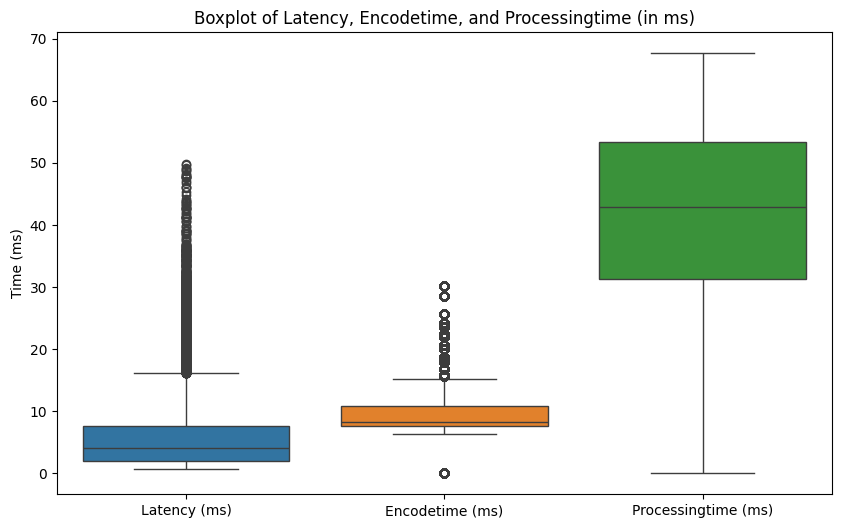

In [38]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 假设 result_df 是之前从 analyze_latency_and_losses() 函数得到的数据
latency_data = result_df['latency']

# 将时延数据从秒转换为毫秒
latency_data_ms = latency_data * 1000
encodetime_ms = data[0] * 1000  # Encodetime 转换为毫秒
processingtime_ms = data[1] * 1000  # Processingtime 转换为毫秒

# 将数据转换为 pandas DataFrame 以便绘制箱线图
data_dict = {
    'Latency (ms)': latency_data_ms,
    'Encodetime (ms)': encodetime_ms,
    'Processingtime (ms)': processingtime_ms
}

df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))  # 将字典转换为DataFrame

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)

# 设置图例、标题和标签
plt.title('Boxplot of Latency, Encodetime, and Processingtime (in ms)')
plt.ylabel('Time (ms)')

# 显示图表
plt.show()


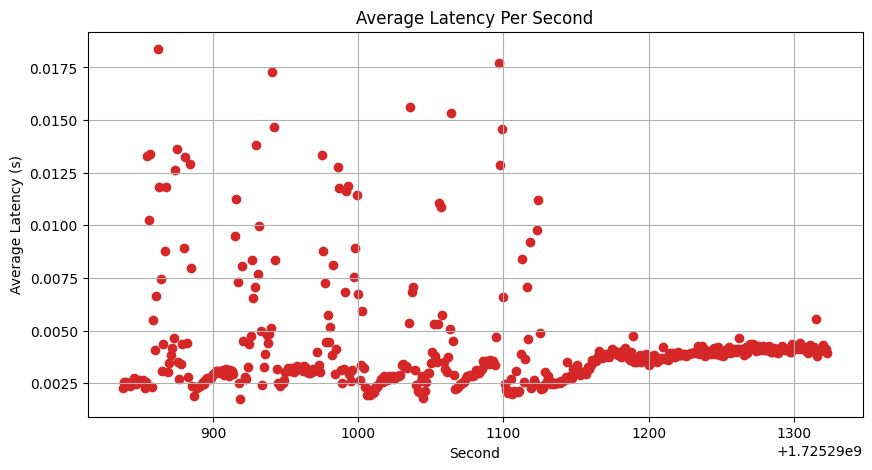

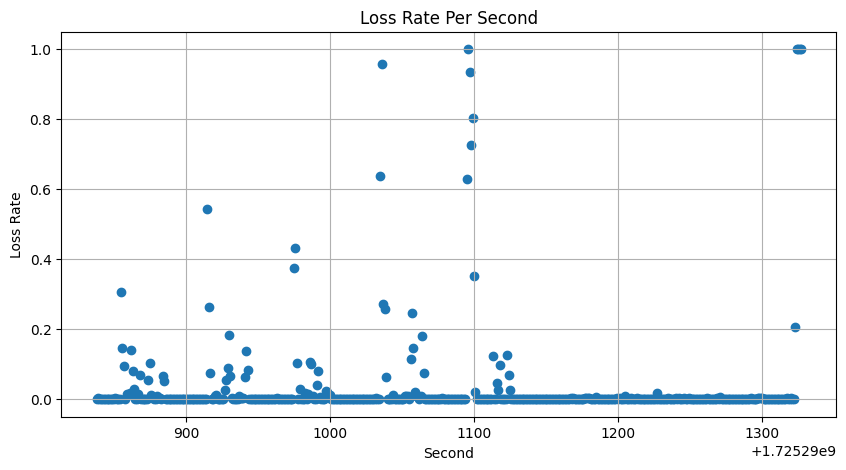

In [5]:
result_df = analyze_latency_and_losses(df1, df2)
df_stats = analyze_per_second(result_df)
plot_latency_and_loss_separately(df_stats)

In [7]:
result_df.to_csv(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090201\cake50ms.csv", index=False)

In [33]:
result_df = analyze_latency_and_losses(df1, df2)

# 打印统计结果
if not result_df['latency'].isna().all():  # 确保至少有一个有效的延迟测量
    print("Latency Statistics:")
    print("Minimum Latency:", result_df['latency'].min())
    print("Maximum Latency:", result_df['latency'].max())
    print("Average Latency:", result_df['latency'].mean())
else:
    print("No valid latency measurements available.")

# 计算丢包率
total_packets = len(result_df)
lost_packets = result_df[result_df['status'] == 'Lost'].shape[0]
loss_rate = (lost_packets / total_packets) * 100

print("Total Packets:", total_packets)
print("Lost Packets:", lost_packets)
print("Loss Rate: {:.2f}%".format(loss_rate))

# 选择性打印result_df的头部，便于查看数据结构
print(result_df.head())

Latency Statistics:
Minimum Latency: 0.000774003
Maximum Latency: 0.049990631
Average Latency: 0.00903132781907817
Total Packets: 32579
Lost Packets: 2964
Loss Rate: 9.10%
         client_time id_code      latency    status
0  1725026471.415048   19261  0.001021693  Received
1  1725026471.415321   19262  0.001233686  Received
2   1725026471.41553   19263  0.001387596  Received
3  1725026471.426764   19264   0.00139235  Received
4  1725026471.427827   19265  0.001948876  Received


Haptic

In [40]:
from scapy.all import rdpcap, UDP,  defragment, IP
import pandas as pd
from decimal import Decimal


def read_haptic_csv(file_path):

    data = pd.read_csv(file_path, header=None, names=['receive', 'send'])


    filtered_data = data[data['send'].astype(str).str.startswith('17')]


    unique_data = filtered_data.drop_duplicates(subset='receive', keep='first')

    return unique_data

In [41]:
def analyze_pcap(pcap_path, udp_port=888):
    packets = rdpcap(pcap_path)
    
    packet_times = {}
    for packet in packets:
        if IP in packet and UDP in packet and packet[UDP].dport == udp_port:
            try:
                payload = bytes(packet[UDP].payload)
            
                timestamp = int.from_bytes(payload[-8:], byteorder='little')
                packet_times[timestamp] = packet.time
            except:
                continue
    return packet_times

In [42]:
def calculate_delays(csv, client_packets, server_packets):
    # Create an empty DataFrame
    df = pd.DataFrame(columns=['send', 'receive', 'app_to_nic', 'nic_to_nic', 'nic_to_app', 'total_delay'])

    
    
    # Iterate through the timing data in the DataFrame
    for index, row in csv.iterrows():
        send = row['send']
        receive = row['receive']
        if send in client_packets and send in server_packets:
            # Convert Decimal to float and multiply by 1000 to convert to milliseconds
            client_time = float(client_packets[send]) * 1000000
            server_time = float(server_packets[send]) * 1000000

            # Build a new row for DataFrame
            new_row = {
                'send': send,
                'receive': receive,
                'app_to_nic': client_time - float(send),
                'nic_to_nic': server_time - client_time,
                'nic_to_app': float(receive) - server_time,
                'total_delay': float(receive) - float(send)
            }
            new_row_df = pd.DataFrame([new_row])  # Convert dictionary to a DataFrame
            df = pd.concat([df, new_row_df], ignore_index=True)

    return df

In [44]:
haptic_csv = read_haptic_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\timelog_haptic_server.txt')

client_haptic_pcap = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\haptic_client_0905.pcapng')

server_haptic_pcap = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\haptic_server_0905.pcapng')

In [45]:

delays = calculate_delays(haptic_csv, client_haptic_pcap, server_haptic_pcap)

delays = delays.drop_duplicates(subset='send', keep='first')

delays.to_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\result\latency_haptic.csv', sep=',', index=False)

Medians of the selected columns:
app_to_nic    -2297.0
nic_to_nic     1951.0
nic_to_app     5288.0
total_delay    6282.0
dtype: float64


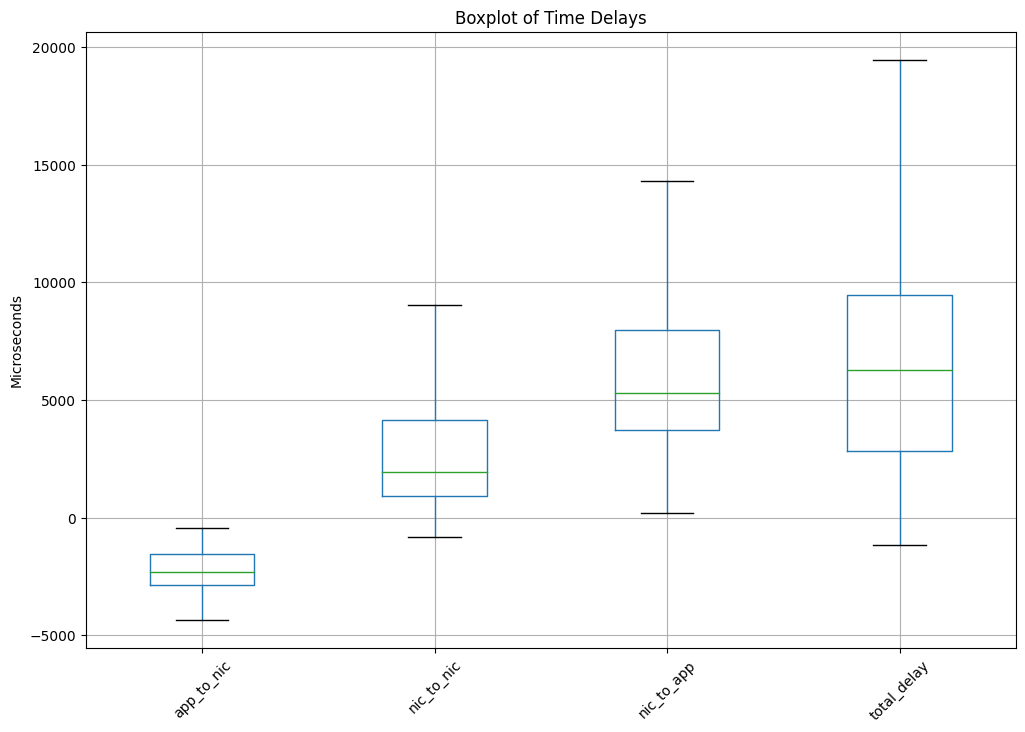

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载CSV文件
df = pd.read_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\result\latency_haptic.csv')

# 选择要绘制的列
columns_to_plot = ["app_to_nic","nic_to_nic","nic_to_app","total_delay"]

medians = df[columns_to_plot].median()
print("Medians of the selected columns:")
print(medians)

# 绘制箱体图
plt.figure(figsize=(12, 8))  # 设置图形大小
df[columns_to_plot].boxplot(showfliers=False)  # 使用DataFrame的boxplot方法绘制
plt.title('Boxplot of Time Delays')  # 添加标题
plt.ylabel('Microseconds')  # 设置y轴标签
plt.xticks(rotation=45)  # 旋转x轴标签，使其更易读
plt.grid(True)  # 添加网格线
plt.show()  # 显示图形

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


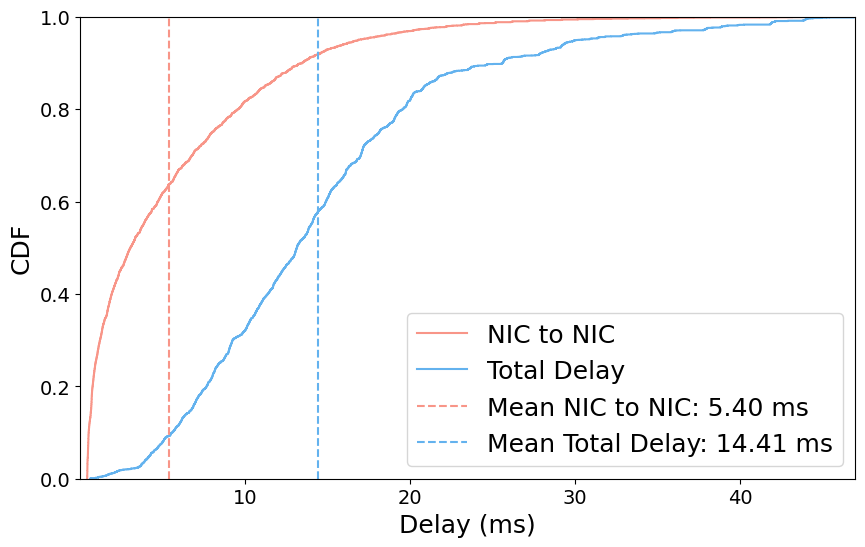

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
df = pd.read_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\old_data\10times_add_0712\latency_haptic.csv')

# Select columns to plot
columns_to_plot = ["app_to_nic", "nic_to_nic", "nic_to_app", "total_delay"]

# Convert values from microseconds to milliseconds and filter out values <= 0
df[columns_to_plot] = df[columns_to_plot] / 1000  # Convert µs to ms
df = df[(df[columns_to_plot] > 0).all(axis=1)]  # Keep only rows where all selected columns are > 0

# Calculate means in milliseconds
mean_app_to_nic = np.mean(df['app_to_nic'])
mean_nic_to_nic = np.mean(df['nic_to_nic'])
mean_nic_to_app = np.mean(df['nic_to_app'])
mean_total_delay = np.mean(df['total_delay'])

# Set figure size
plt.figure(figsize=(10, 6))

# Plot CDF using seaborn for each column
# sns.ecdfplot(df['app_to_nic'], label='App to NIC', color='blue')
sns.ecdfplot(df['nic_to_nic'], label='NIC to NIC', color='#f89588')
# sns.ecdfplot(df['nic_to_app'], label='NIC to App', color='orange')
sns.ecdfplot(df['total_delay'], label='Total Delay', color='#63b2ee')

# Mark the means on the plot
# plt.axvline(mean_app_to_nic, color='blue', linestyle='--', label=f'Mean App to NIC: {mean_app_to_nic:.2f} ms')
plt.axvline(mean_nic_to_nic, color='#f89588', linestyle='--', label=f'Mean NIC to NIC: {mean_nic_to_nic:.2f} ms')
# plt.axvline(mean_nic_to_app, color='orange', linestyle='--', label=f'Mean NIC to App: {mean_nic_to_app:.2f} ms')
plt.axvline(mean_total_delay, color='#63b2ee', linestyle='--', label=f'Mean Total Delay: {mean_total_delay:.2f} ms')

# Set X-axis limits from the minimum to maximum value in milliseconds
plt.xlim(df[columns_to_plot].min().min(), df[columns_to_plot].max().max())

# Add title and labels
# plt.title('CDF Plot of App to NIC, NIC to NIC, NIC to App, and Total Delay (in ms)')
plt.xlabel('Delay (ms)', fontsize = 18)
plt.ylabel('CDF', fontsize = 18)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# Add legend
plt.legend(fontsize = 18)

plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\CDF_haptic_latency.eps")
plt.savefig(r"C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\figures\methods\CDF_haptic_latency.png")

# Show the plot
# plt.grid(True)
plt.show()  # Display the plot


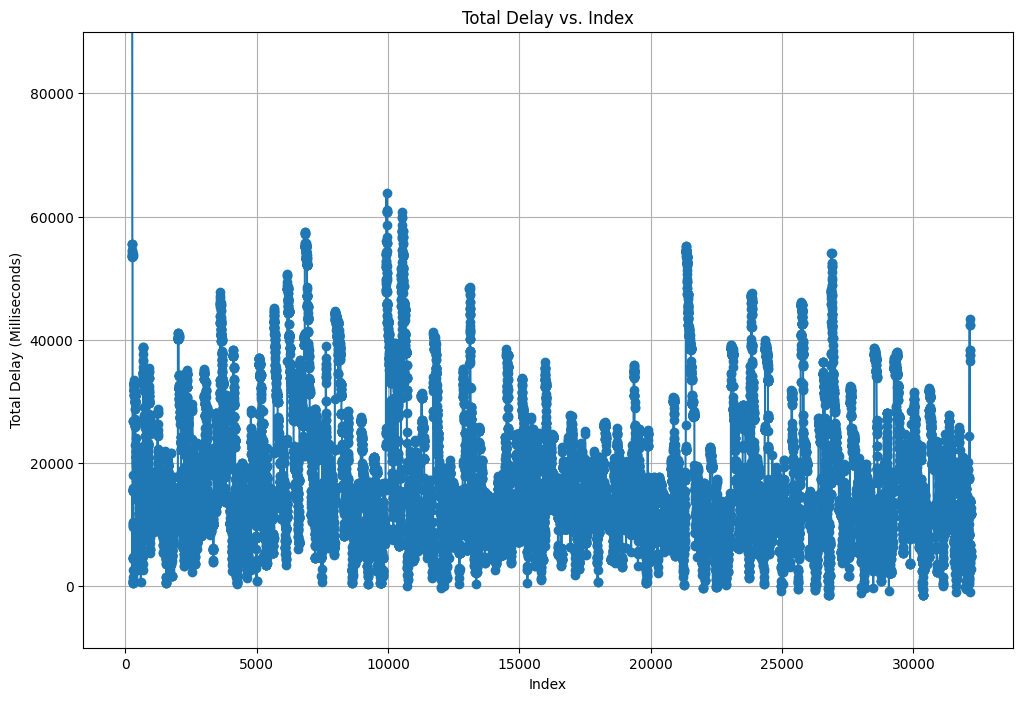

In [35]:
# 加载CSV文件
df = pd.read_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\10times_add_071702\latency_haptic.csv')

# 绘制折线图
plt.figure(figsize=(12, 8))  # 设置图形大小
plt.plot(df.index, df["total_delay"], marker='o')  # 使用DataFrame的plot方法绘制折线图
plt.title('Total Delay vs. Index')  # 添加标题
plt.xlabel('Index')  # 设置x轴标签
plt.ylabel('Total Delay (Milliseconds)')  # 设置y轴标签
plt.ylim(-10000, 90000)  # 设置y轴范围
plt.grid(True)  # 添加网格线
plt.show()  # 显示图形

In [55]:
haptic_csv = read_haptic_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0709\timelog_haptic.txt')

client_haptic_pcap = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0709\10times_add_client_haptic_0709.pcapng')

server_haptic_pcap = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0709\10times_add_server_0709.pcapng')

In [56]:
delays = calculate_delays(haptic_csv, client_haptic_pcap, server_haptic_pcap)

delays = delays.drop_duplicates(subset='send', keep='first')

delays.to_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0709\latency_haptic.csv', sep=',', index=False)

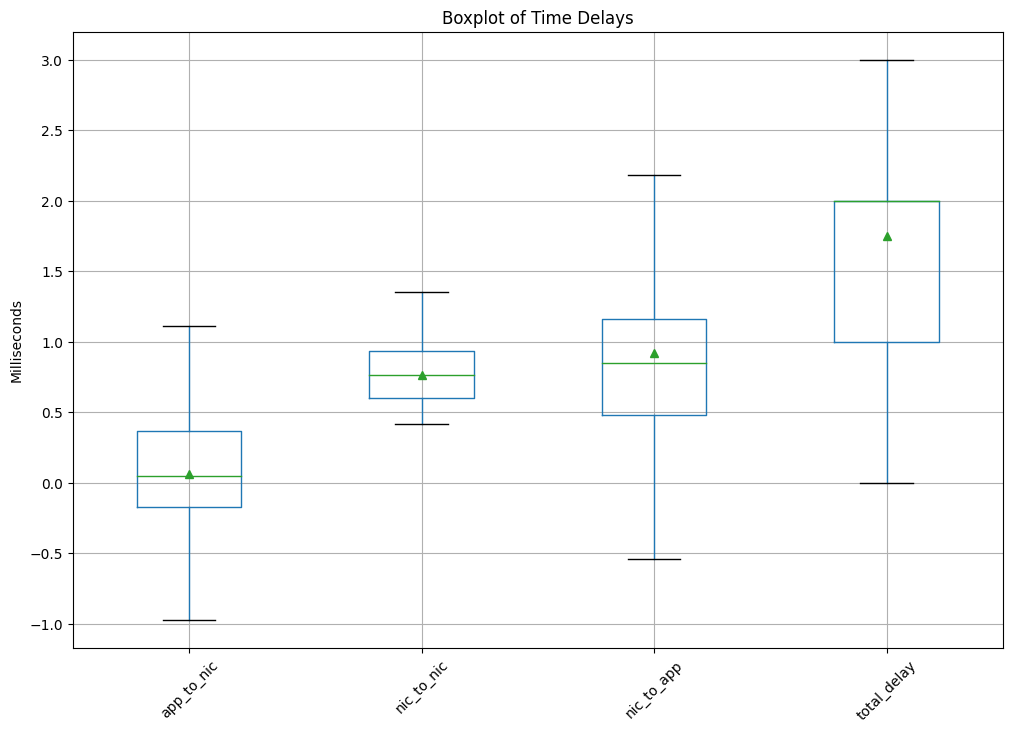

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载CSV文件
df = pd.read_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0709\latency_haptic.csv')

# 选择要绘制的列
columns_to_plot = ["app_to_nic","nic_to_nic","nic_to_app","total_delay"]

# 绘制箱体图
plt.figure(figsize=(12, 8))  # 设置图形大小
df[columns_to_plot].boxplot(showfliers=False, showmeans= True)  # 使用DataFrame的boxplot方法绘制
plt.title('Boxplot of Time Delays')  # 添加标题
plt.ylabel('Milliseconds')  # 设置y轴标签
plt.xticks(rotation=45)  # 旋转x轴标签，使其更易读
plt.grid(True)  # 添加网格线
plt.show()  # 显示图形

In [58]:
haptic_csv = read_haptic_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0710\timelog_haptic.txt')

client_haptic_pcap = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0710\10times_add_client_haptic_0710.pcapng')

server_haptic_pcap = analyze_pcap(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0710\10times_add_server_0710.pcapng')

In [59]:

delays = calculate_delays(haptic_csv, client_haptic_pcap, server_haptic_pcap)

delays = delays.drop_duplicates(subset='send', keep='first')

delays.to_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0710\latency_haptic.csv', sep=',', index=False)

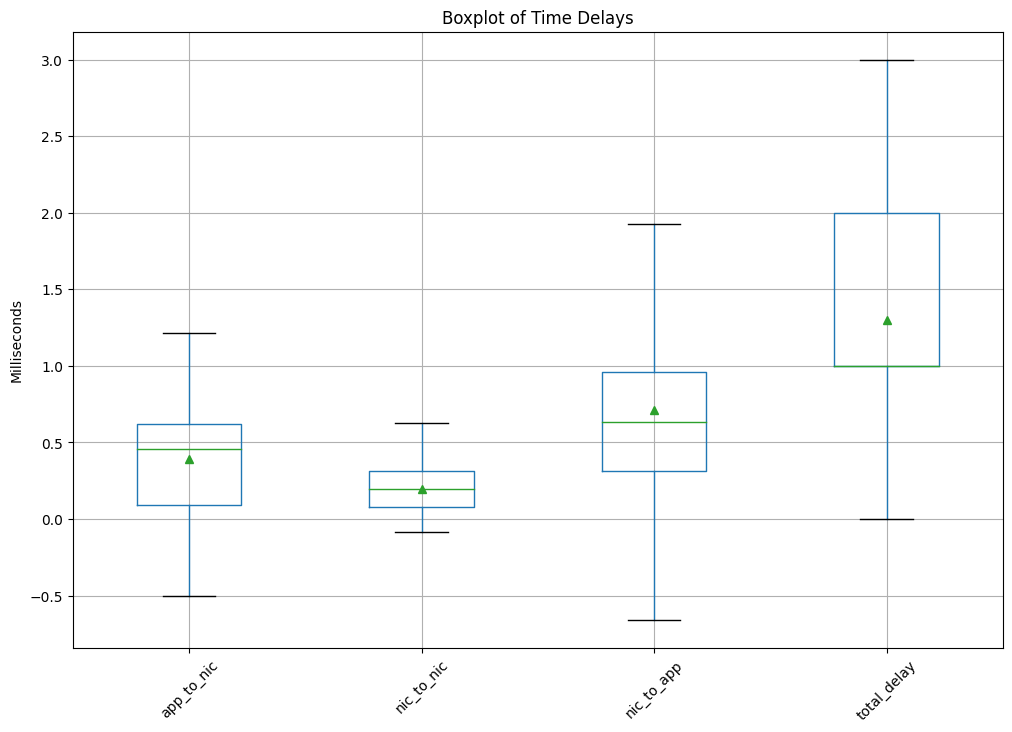

In [60]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\da_multimedia\10times_add_0710\latency_haptic.csv')


columns_to_plot = ["app_to_nic","nic_to_nic","nic_to_app","total_delay"]


plt.figure(figsize=(12, 8))  
df[columns_to_plot].boxplot(showfliers=False, showmeans= True)  
plt.title('Boxplot of Time Delays')  
plt.ylabel('Milliseconds')  
plt.xticks(rotation=45)  
plt.grid(True)  
plt.show()  

## Transfer bin file to txt file

In [ ]:
import numpy as np

# 指定你的 .bin 文件路径
bin_file_path = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\timelog_haptic_server.bin'
txt_file_path = r'C:\Users\Administrator\Desktop\Diplom_arbeit\da_multimedia_data\090501\timelog_haptic_server.txt'

# 使用 numpy 从 .bin 文件中以 int64 的格式读取数据
timestamps = np.fromfile(bin_file_path, dtype=np.int64)

# 打开一个新的 txt 文件用于写入
with open(txt_file_path, 'w') as txt_file:
    # 每两个时间戳写入一行
    for i in range(0, len(timestamps), 2):
        # 如果 timestamps 的数量是奇数，最后一个单独处理
        if i + 1 < len(timestamps):
            txt_file.write(f"{timestamps[i]},{timestamps[i+1]}\n")
        else:
            txt_file.write(f"{timestamps[i]}\n")  # 最后一个时间戳单独一行

print("Finished")


转换完成。
